# Location, Production, and Transportation
### Multi-objective optimization example in Decision Analytics for Business and Policy
##### Goal programming approach

### Import packages

In [7]:
from gurobipy import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

### Set up model parameters

In [8]:
# Warehouse demand in thousands of units
demand = pd.read_csv('demand.csv', index_col=None, header=None).values

# Plant capacity in thousands of units
capacity = [20, 22, 17, 19, 18]

# Fixed costs for each plant
fixedCosts = [12000, 15000, 17000, 13000, 16000]

prodCosts = [45.9, 60.2, 50.0, 35.1, 30.0]

# Transportation costs per thousand units
transportationCosts = pd.read_csv('transportationCost.csv', index_col=None, header=None).values

# Indices for plants and markets
plants = range(len(capacity))
markets = range(len(demand))

### Set up optimization model

In [9]:
# Setting up model object
m = Model("facility")

### Setting up Decision Variables ###
# Plant open decision variables: x[i] == 1 if plant i is open.
x = m.addVars(plants, vtype=GRB.BINARY)

# production variables
y = m.addVars(plants, lb = 0.0)

# Transportation decision variables: w[i,j] is the
# quantity to transport from plant i to market j
w = m.addVars(plants, markets, lb = 0.0)

# Set up two variables to capture the two objectives 
z1 = m.addVar(lb = 0.0) # for location + production cost
z2 = m.addVar(lb = 0.0) # for transportation cost


setupCost = LinExpr() # facility setup cost
for i in plants:
    setupCost += fixedCosts[i] * x[i]
    
productionCost = LinExpr() # production cost
for i in plants:
    productionCost += prodCosts[i] * y[i]

shipmentCost = LinExpr() # transportation cost
for i in plants:
    for j in markets:
        shipmentCost += transportationCosts[i,j] * w[i,j]
        
m.addConstr(z1 == setupCost + productionCost)
m.addConstr(z2 == shipmentCost)

### Constraints ###
# Production and shipment constraints
# Note that the right-hand limit sets the production to zero if the plant
# is closed
for i in plants:
  m.addConstr(sum(w[i,j] for j in markets) <= y[i])
  m.addConstr(y[i] <= capacity[i] * x[i])


# Demand constraints
for j in markets:
  m.addConstr(sum(w[i,j] for i in plants) >= demand[j])

#### To find the initial upper bound K for z2 cost, we can minimize z2 without worrying about z1 first. This gives us the best (smallest) z2 value we can achieve. 

In [10]:
m.setObjective(z2, GRB.MINIMIZE)
m.optimize()

min_shipment_cost = z2.x

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0xdcf254b3
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+01]
Presolve removed 7 rows and 12 columns
Presolve time: 0.00s
Presolved: 9 rows, 20 columns, 40 nonzeros
Variable types: 20 continuous, 0 integer (0 binary)

Root relaxation: objective 1.539000e+05, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    153900.00000 153900.000  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution coun

### Goal Approach

In [11]:
multiples = np.arange(1,1.3,0.005)

costs = np.zeros([len(multiples), 2])

m.setObjective(z1, GRB.MINIMIZE)

for iteration in range(len(multiples)):
    
    multiple = multiples[iteration]
    z2.ub = min_shipment_cost * multiple
    m.optimize()
    
    costs[iteration, 0] = z1.x
    costs[iteration, 1] = z2.x

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0x5f9a1252
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 76209.3 (0.00s)
Loaded MIP start from previous solve with objective 76209.3

Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 4.920930e+04, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 49209.3000    0    1 76209.3000 49209.

  Flow cover: 1

Explored 1 nodes (25 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 58925.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.892577583333e+04, best bound 5.892577583333e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0x07e04676
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 58887 (0.00s)
Loaded MIP start from previous solve with objective 58887

Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root


     0     0 48422.6333    0    1 58755.1521 48422.6333  17.6%     -    0s
     0     0     cutoff    0      58755.1521 58755.1521  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Implied bound: 1
  MIR: 1
  Flow cover: 1

Explored 1 nodes (38 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 58755.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.875515210000e+04, best bound 5.875515210000e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0xb0267a7b
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 58731.9 (0.00s)
Loaded MI

Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 4.842263e+04, 30 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 48422.6333    0    1 58726.9000 48422.6333  17.5%     -    0s
     0     0     cutoff    0      58726.9000 58726.9000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Implied bound: 1
  MIR: 2
  Flow cover: 1

Explored 1 nodes (30 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 58726.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.872690000000e+04, best bound 5.872690000000e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 no

Loaded MIP start from previous solve with objective 58726.9

Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 4.842263e+04, 18 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 48422.6333    0    1 58726.9000 48422.6333  17.5%     -    0s
     0     0     cutoff    0      58726.9000 58726.9000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  MIR: 1
  Flow cover: 1

Explored 1 nodes (18 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 58726.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.872690000000e+04, best bound 5.872690000000e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical proce

  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 58726.9 (0.00s)
Loaded MIP start from previous solve with objective 58726.9

Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 4.842263e+04, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 48422.6333    0    1 58726.9000 48422.6333  17.5%     -    0s
     0     0     cutoff    0      58726.9000 58726.9000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  Implied bound: 1
  MIR: 2
  Flow cover: 1

Explored 1 nodes (16 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 58726.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.872690000000e+04, best bound 5

Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0x8a88ed09
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 58726.9 (0.00s)
Loaded MIP start from previous solve with objective 58726.9

Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 4.842263e+04, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 48422.6333    0    1 58726.9000 48422.6333  17.5%     -    0s
     0     0     cutoff    0      58726.9000 58726.9000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  I

Best objective 5.872690000000e+04, best bound 5.872690000000e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0x32cf212c
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 58726.9 (0.00s)
Loaded MIP start from previous solve with objective 58726.9

Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 4.842263e+04, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be


Solution count 1: 58726.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.872690000000e+04, best bound 5.872690000000e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0xdb15556f
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 58726.9 (0.00s)
Loaded MIP start from previous solve with objective 58726.9

Presolve removed 6 rows and 7 columns
Presolve time: 0.00s
Presolved: 10 rows, 25 columns, 65 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 4.842263e+04, 20 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective B

     0     0     cutoff    0      58726.9000 58726.9000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  MIR: 1
  Flow cover: 1

Explored 1 nodes (20 simplex iterations) in 0.02 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 58726.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.872690000000e+04, best bound 5.872690000000e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0x835b8974
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 58726.9 (0.01s)
Loaded MIP start from previous solve with objective 58726.9

Presolve removed 6 rows and 7 columns
Preso

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 48422.6333    0    1 58726.9000 48422.6333  17.5%     -    0s
     0     0     cutoff    0      58726.9000 58726.9000  0.00%     -    0s

Cutting planes:
  Gomory: 1
  MIR: 1
  Flow cover: 1

Explored 1 nodes (18 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 58726.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.872690000000e+04, best bound 5.872690000000e+04, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0x2ba1bd97
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve 

[[ 60209.3        153900.        ]
 [ 59080.70183333 154669.5       ]
 [ 59041.97033333 155439.        ]
 [ 59003.23883333 156208.5       ]
 [ 58964.50733333 156978.        ]
 [ 58925.77583333 157747.5       ]
 [ 58887.04433333 158517.        ]
 [ 58848.3777     159286.5       ]
 [ 58824.8688     160056.        ]
 [ 58801.6299     160825.5       ]
 [ 58778.391      161595.        ]
 [ 58755.1521     162364.5       ]
 [ 58731.9132     163134.        ]
 [ 58726.9        163903.5       ]
 [ 58726.9        164673.        ]
 [ 58726.9        165442.5       ]
 [ 58726.9        166212.        ]
 [ 58726.9        166981.5       ]
 [ 58726.9        167751.        ]
 [ 58726.9        168520.5       ]
 [ 58726.9        169290.        ]
 [ 58726.9        170059.5       ]
 [ 58726.9        170829.        ]
 [ 58726.9        171598.5       ]
 [ 58726.9        172368.        ]
 [ 58726.9        173137.5       ]
 [ 58726.9        173907.        ]
 [ 58726.9        174676.5       ]
 [ 58726.9        17

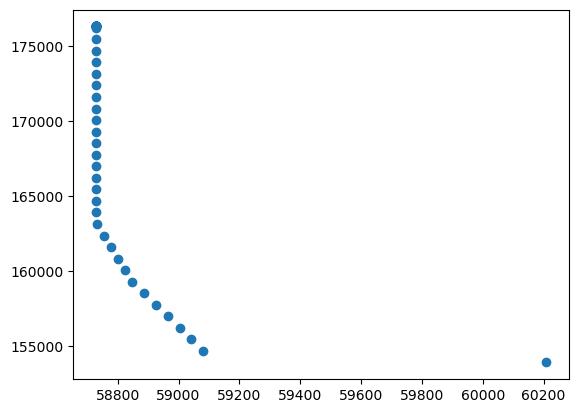

In [12]:
# Plot Pareto frontier
print(costs)
plt.scatter(costs[:,0],costs[:,1])
plt.show()

## Discussion

* How is this plot different from the one generated from the weighted approach?
* Why are they different? (Check slides)
* What would happen if we were to minimize z2 while limiting the cost z1? How would the plot look like?
* Note: in each iteration of the for-loop, I solved a different instance of optimization problem. The difference is only in the upperbound of z2, all other things remained intact. So I only needed to reset the upperbound of z2 by stating z2.ub = some_new_bound every time.